In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 

dataset_fname = 'toolsdata/bursi.pos.gspan'

In [23]:
%%time
# induce a grammar and train an estimator
training_graphs = get_graphs(dataset_fname, size=100)

from graphlearn.graphlearn import Sampler
from eden.graph import Vectorizer
sampler=Sampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,
                          vectorizer=Vectorizer(3))
sampler.fit(training_graphs)

print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))
sampler.save('tmp/sampler.ge')

#instances: 100  #interfaces: 45   #cores: 35   #core-interface-pairs: 135
graph grammar stats:
#instances: 100   #interfaces: 45   #cores: 35   #core-interface-pairs: 135
Saved model: tmp/sampler.ge
CPU times: user 1.65 s, sys: 252 ms, total: 1.9 s
Wall time: 3.49 s


In [24]:
%%time
from graphlearn.graphlearn import Sampler
sampler=Sampler()
sampler.load('tmp/sampler.ge')

# graph sampling
graphs = get_graphs(dataset_fname, size=100)

id_start=34
id_end=id_start+12
from itertools import islice
input_graphs = islice(graphs,id_start,id_end)

# sample
n_steps=20
n_samples=3

graphs = sampler.sample(input_graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        target_orig_cip=False,
                        probabilistic_core_choice=False,
                        score_core_choice= True,
                        max_size_diff=-1,
                        burnin=1,
                        omit_seed=False,
                        proposal_probability = True,
                        improving_threshold=.8, 
                        improving_linear_start=0.2,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=True,  
                        monitor=True)



Loaded model: tmp/sampler.ge
CPU times: user 120 ms, sys: 20 ms, total: 140 ms
Wall time: 142 ms


preprocessing grammar
_sample_notes: None
accept_static_penalty: 0.0
batch_size: 10
    burnin: 1
estimatorobject: <graphlearn.estimator.Wrapper instance at 0x7fee25e7c320>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7fee25e7c950>
generator_mode: False
hash_bitmask: 1048575
improving_linear_start: 4
improving_penalty_per_step: 0.0833333333333
improving_threshold: 16
keep_duplicates: True
      lsgg: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x7fee24ab6cd0>
max_core_size_diff: -2
maxbacktrack: 0
   monitor: True
  monitors: []
    n_jobs: 1
   n_steps: 20
      nbit: 20
node_entity_check: <function <lambda> at 0x7fee3c450cf8>
 omit_seed: False
postprocessor: <graphlearn.processing.PostProcessor object at 0x7fee240cdb50>
preprocessor: <graphlearn.processing.PreProcessor object at 0x7fee28db3610>
probabilistic_core_choice: False
proposal_probability: True
quick_skip_orig_cip: False
radius_list: [0, 2]
random_state

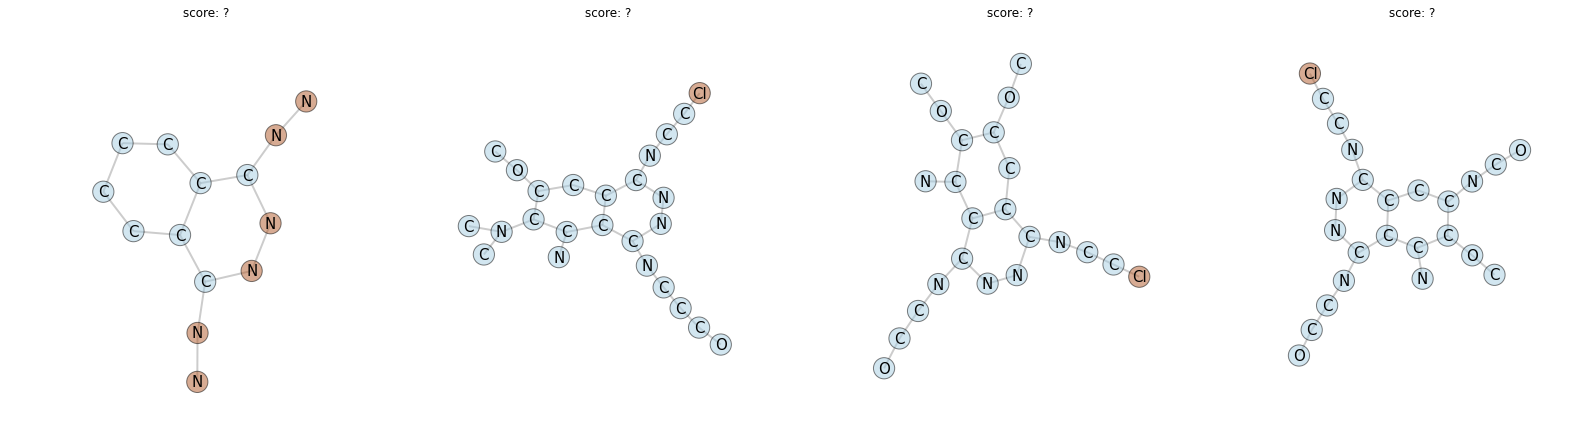

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 43
_propose_graph: iteration 1 ; core 0 of 3 ; original_cips tried  0 ; size 43
_propose_graph: iteration 2 ; core 0 of 1 ; original_cips tried  0 ; size 43
_propose_graph: iteration 3 ; core 0 of 3 ; original_cips tried  0 ; size 43
_propose_graph: iteration 4 ; core 0 of 5 ; original_cips tried  0 ; size 43
_propose_graph: iteration 5 ; core 0 of 9 ; original_cips tried  0 ; size 49
_propose_graph: iteration 6 ; core 0 of 5 ; original_cips tried  0 ; size 49
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0 ; size 53
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0 ; size 55
_propose_graph: iteration 9 ; core 0 of 5 ; original_cips tried  0 ; size 53
_propose_graph: iteration 10 ; core 0 of 5 ; original_cips tried  0 ; size 53
_propose_graph: iteration 11 ; core 0 of 1 ; original_cips tried  0 ; size 53
_propose_graph: iteration 12 ; core 0 of 2 ; original_cips tried  0 ; size

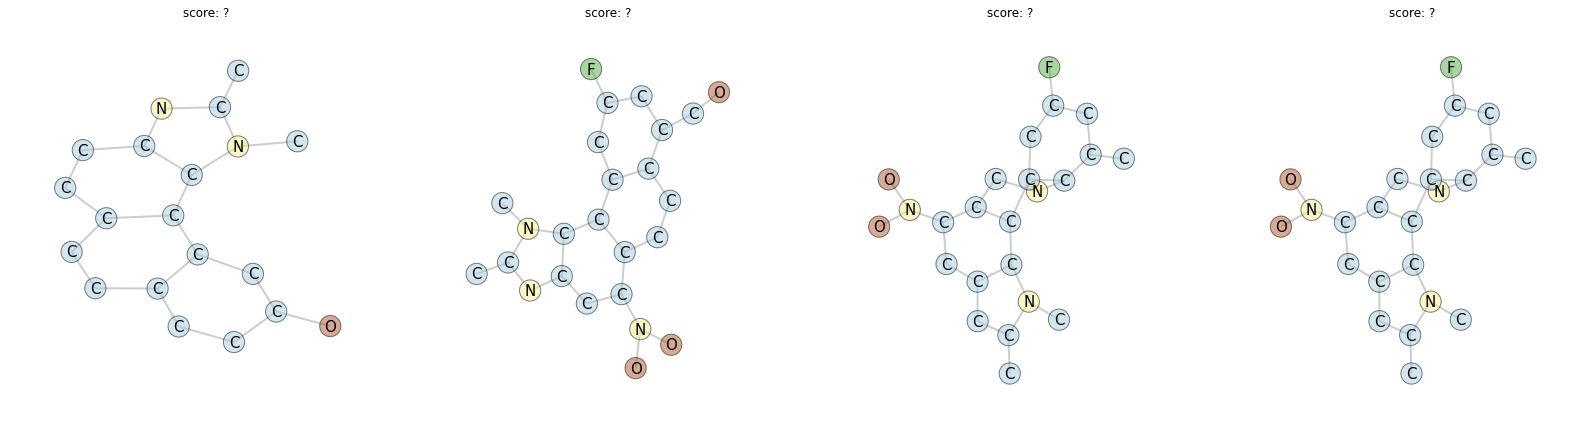

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 24
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 30
_propose_graph: iteration 2 ; core 0 of 10 ; original_cips tried  0 ; size 28
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0 ; size 26
_propose_graph: iteration 4 ; core 0 of 10 ; original_cips tried  0 ; size 28
_propose_graph: iteration 5 ; core 0 of 10 ; original_cips tried  0 ; size 28
_propose_graph: iteration 6 ; core 0 of 10 ; original_cips tried  0 ; size 28
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0 ; size 32
_propose_graph: iteration 8 ; core 0 of 3 ; original_cips tried  0 ; size 32
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0 ; size 34
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0 ; size 34
_propose_graph: iteration 11 ; core 0 of 2 ; original_cips tried  0 ; size 34
_propose_graph: iteration 12 ; core 0 of 2 ; original_cips tried  0 ; 

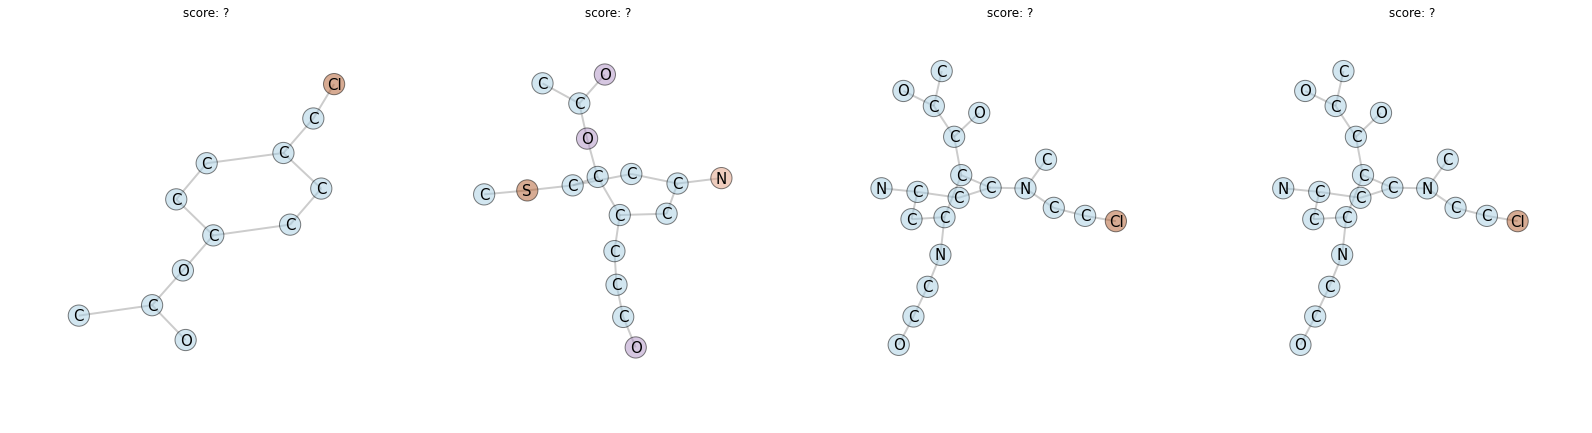

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 35
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 39
_propose_graph: iteration 2 ; core 0 of 1 ; original_cips tried  0 ; size 45
_propose_graph: iteration 3 ; core 0 of 3 ; original_cips tried  0 ; size 47
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0 ; size 49
_propose_graph: iteration 5 ; core 0 of 9 ; original_cips tried  0 ; size 47
_propose_graph: iteration 6 ; core 0 of 2 ; original_cips tried  0 ; size 51
_propose_graph: iteration 7 ; core 0 of 5 ; original_cips tried  0 ; size 55
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0 ; size 59
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0 ; size 55
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0 ; size 57
_propose_graph: iteration 11 ; core 0 of 1 ; original_cips tried  0 ; size 59
_propose_graph: iteration 12 ; core 0 of 10 ; original_cips tried  0 ; siz

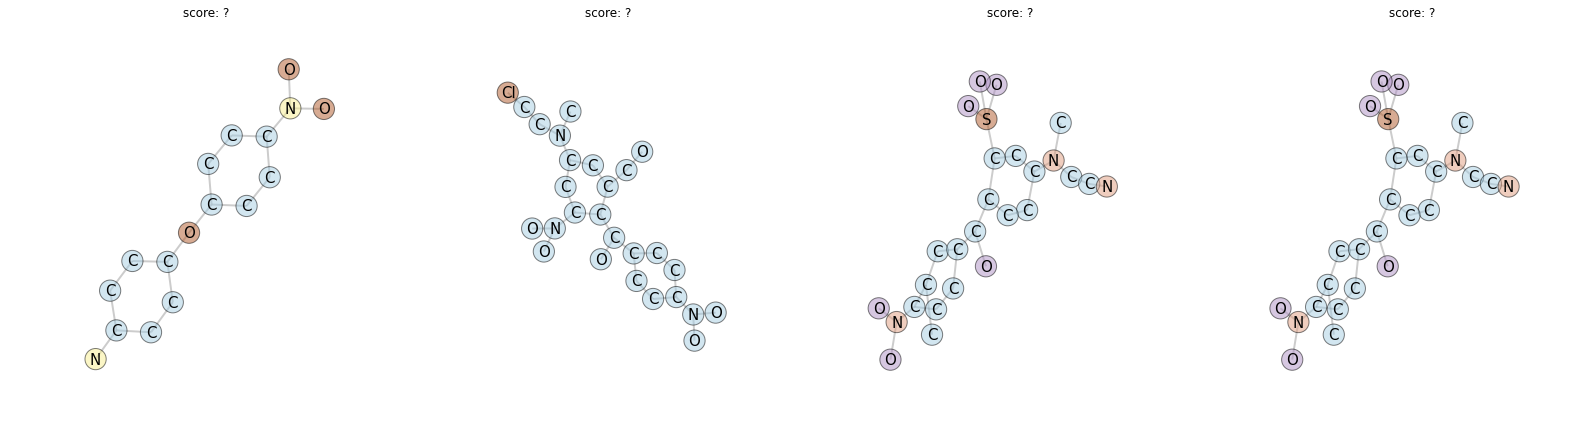

_propose_graph: iteration 0 ; core 0 of 2 ; original_cips tried  0 ; size 43
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 47
_propose_graph: iteration 2 ; core 0 of 2 ; original_cips tried  0 ; size 49
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0 ; size 51
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0 ; size 53
_propose_graph: iteration 5 ; core 0 of 10 ; original_cips tried  0 ; size 57
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0 ; size 57
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0 ; size 55
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0 ; size 57
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0 ; size 59
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 57
_propose_graph: iteration 11 ; core 0 of 1 ; original_cips tried  0 ; size 57
_propose_graph: iteration 12 ; core 0 of 2 ; original_cips tried  0 ; siz

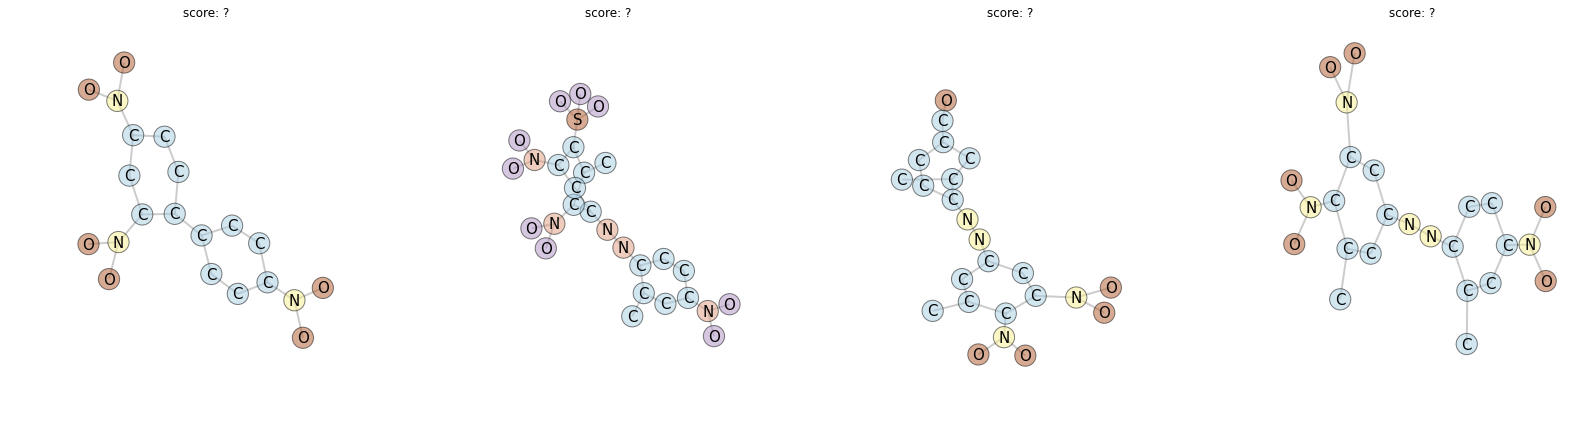

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 22
_propose_graph: iteration 1 ; core 0 of 9 ; original_cips tried  0 ; size 18
_propose_graph: iteration 2 ; core 0 of 9 ; original_cips tried  0 ; size 18
_propose_graph: iteration 3 ; core 0 of 9 ; original_cips tried  0 ; size 16
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 5 ; core 0 of 2 ; original_cips tried  0 ; size 22
_propose_graph: iteration 6 ; core 0 of 10 ; original_cips tried  0 ; size 20
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0 ; size 24
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0 ; size 28
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0 ; size 24
_propose_graph: iteration 10 ; core 0 of 10 ; original_cips tried  0 ; size 28
_propose_graph: iteration 11 ; core 0 of 9 ; original_cips tried  0 ; size 28
_propose_graph: iteration 12 ; core 0 of 2 ; original_cips tried  0 ; si

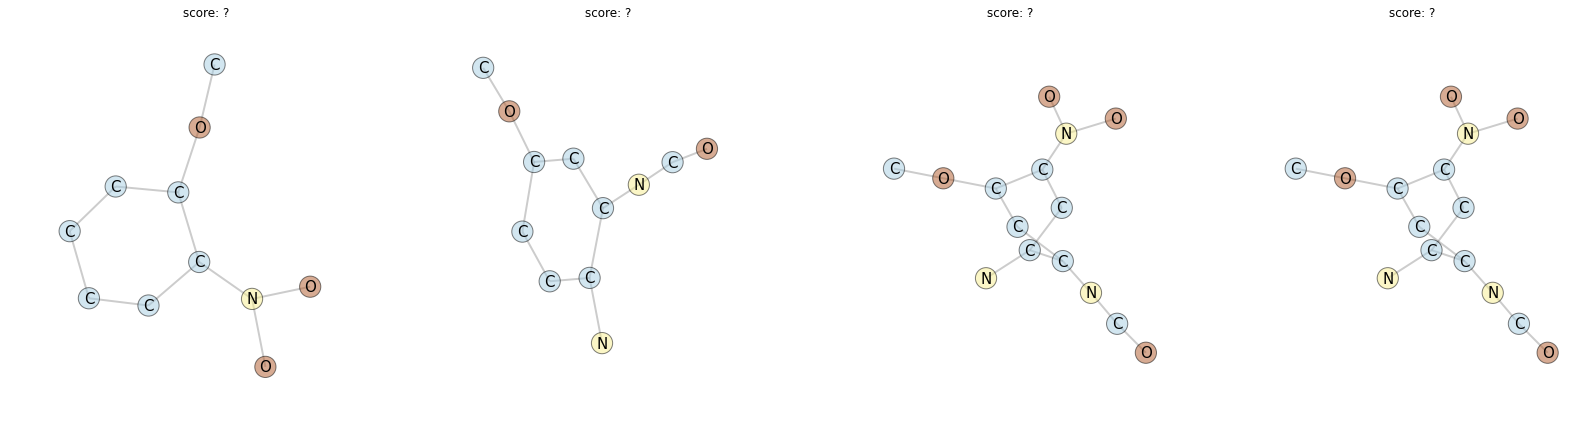

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 39
_propose_graph: iteration 1 ; core 0 of 5 ; original_cips tried  0 ; size 39
_propose_graph: iteration 2 ; core 0 of 5 ; original_cips tried  0 ; size 45
_propose_graph: iteration 3 ; core 0 of 5 ; original_cips tried  0 ; size 45
_propose_graph: iteration 4 ; core 0 of 2 ; original_cips tried  0 ; size 47
_propose_graph: iteration 5 ; core 0 of 10 ; original_cips tried  0 ; size 49
_propose_graph: iteration 6 ; core 0 of 5 ; original_cips tried  0 ; size 49
_propose_graph: iteration 7 ; core 0 of 5 ; original_cips tried  0 ; size 49
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0 ; size 49
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0 ; size 49
_propose_graph: iteration 10 ; core 0 of 5 ; original_cips tried  0 ; size 49
_propose_graph: iteration 11 ; core 0 of 5 ; original_cips tried  0 ; size 51
_propose_graph: iteration 12 ; core 0 of 9 ; original_cips tried  0 ; siz

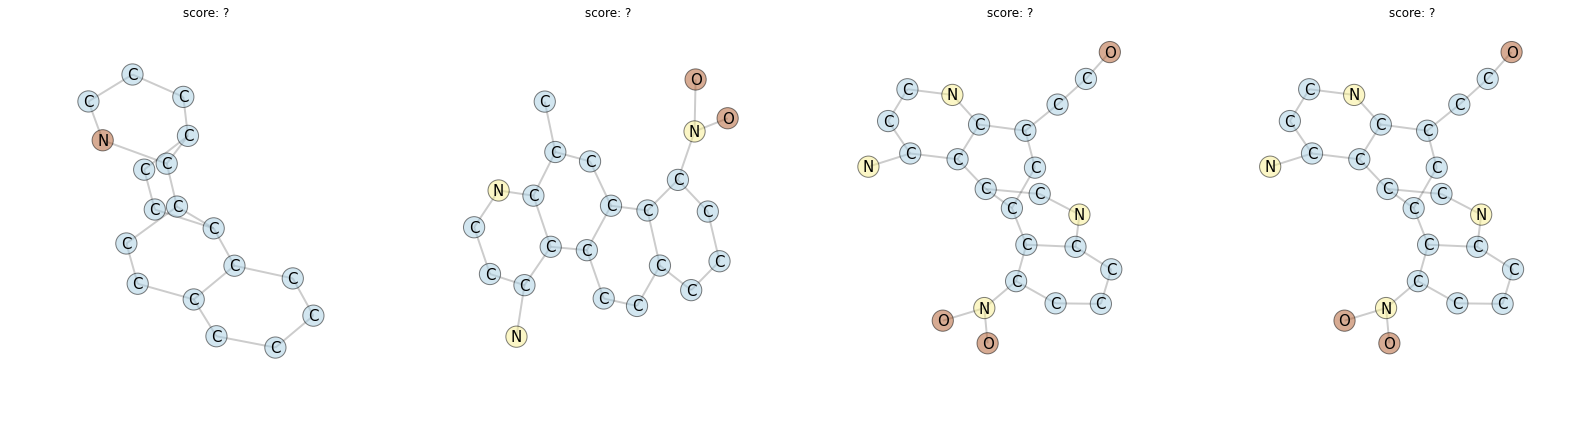

_propose_graph: iteration 0 ; core 0 of 3 ; original_cips tried  0 ; size 52
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 54
_propose_graph: iteration 2 ; core 0 of 3 ; original_cips tried  0 ; size 54
_propose_graph: iteration 3 ; core 0 of 4 ; original_cips tried  0 ; size 54
_propose_graph: iteration 4 ; core 0 of 4 ; original_cips tried  0 ; size 56
_propose_graph: iteration 5 ; core 0 of 4 ; original_cips tried  0 ; size 56
_propose_graph: iteration 6 ; core 0 of 5 ; original_cips tried  0 ; size 58
_propose_graph: iteration 7 ; core 0 of 4 ; original_cips tried  0 ; size 52
_propose_graph: iteration 8 ; core 0 of 9 ; original_cips tried  0 ; size 52
_propose_graph: iteration 9 ; core 0 of 3 ; original_cips tried  0 ; size 50
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 52
_propose_graph: iteration 11 ; core 0 of 2 ; original_cips tried  0 ; size 54
_propose_graph: iteration 12 ; core 0 of 1 ; original_cips tried  0 ; size

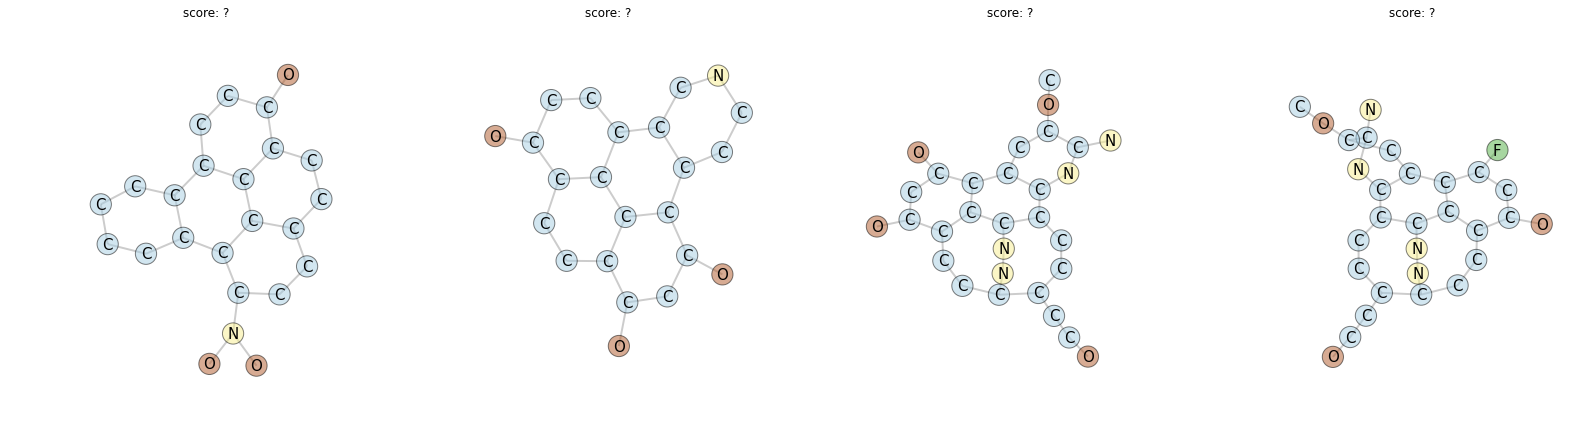

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 107
_propose_graph: iteration 1 ; core 0 of 2 ; original_cips tried  0 ; size 99
_propose_graph: iteration 2 ; core 0 of 9 ; original_cips tried  0 ; size 99
_propose_graph: iteration 3 ; core 0 of 9 ; original_cips tried  0 ; size 105
_propose_graph: iteration 4 ; core 0 of 2 ; original_cips tried  0 ; size 103
_propose_graph: iteration 5 ; core 0 of 9 ; original_cips tried  0 ; size 107
_propose_graph: iteration 6 ; core 1 of 1 ; original_cips tried  0 ; size 105
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0 ; size 105
_propose_graph: iteration 8 ; core 0 of 2 ; original_cips tried  0 ; size 103
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0 ; size 105
_propose_graph: iteration 10 ; core 0 of 9 ; original_cips tried  0 ; size 105
_propose_graph: iteration 11 ; core 0 of 2 ; original_cips tried  0 ; size 107
_propose_graph: iteration 12 ; core 0 of 2 ; original_cips tried

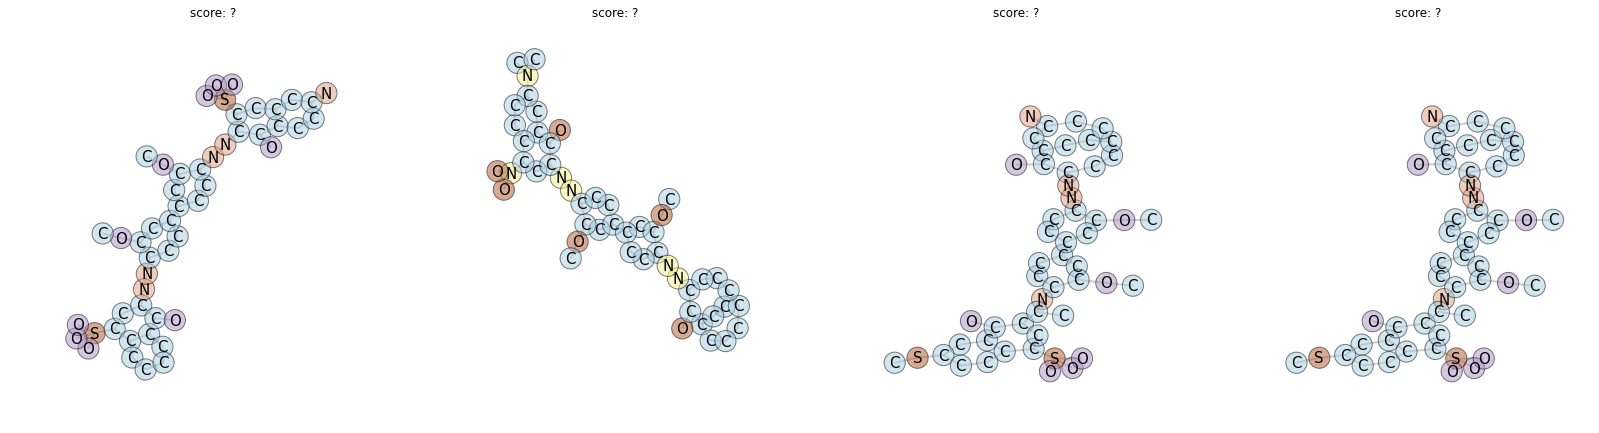

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 32
_propose_graph: iteration 1 ; core 0 of 9 ; original_cips tried  0 ; size 30
_propose_graph: iteration 2 ; core 0 of 9 ; original_cips tried  0 ; size 26
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0 ; size 18
_propose_graph: iteration 5 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0 ; size 22
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 11 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 12 ; core 0 of 1 ; original_cips tried  0 ; size

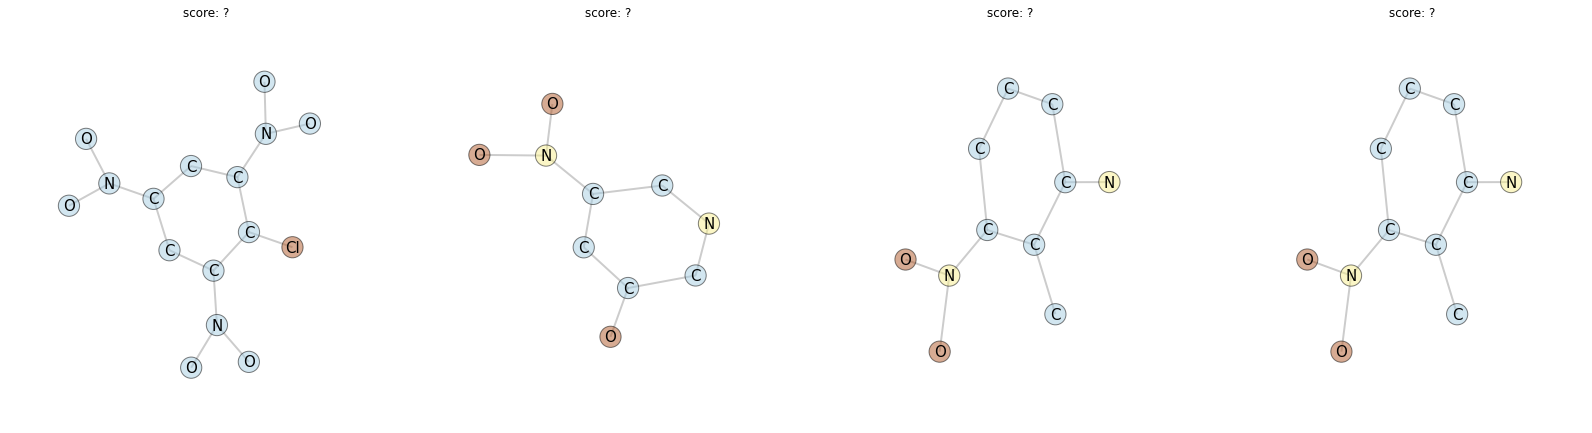

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 38
_propose_graph: iteration 1 ; core 0 of 9 ; original_cips tried  0 ; size 32
_propose_graph: iteration 2 ; core 0 of 1 ; original_cips tried  0 ; size 34
_propose_graph: iteration 3 ; core 0 of 9 ; original_cips tried  0 ; size 38
_propose_graph: iteration 4 ; core 0 of 9 ; original_cips tried  0 ; size 42
_propose_graph: iteration 5 ; core 0 of 9 ; original_cips tried  0 ; size 40
_propose_graph: iteration 6 ; core 0 of 10 ; original_cips tried  0 ; size 42
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0 ; size 42
_propose_graph: iteration 8 ; core 0 of 2 ; original_cips tried  0 ; size 44
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0 ; size 48
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 50
_propose_graph: iteration 11 ; core 0 of 1 ; original_cips tried  0 ; size 52
_propose_graph: iteration 12 ; core 0 of 9 ; original_cips tried  0 ; siz

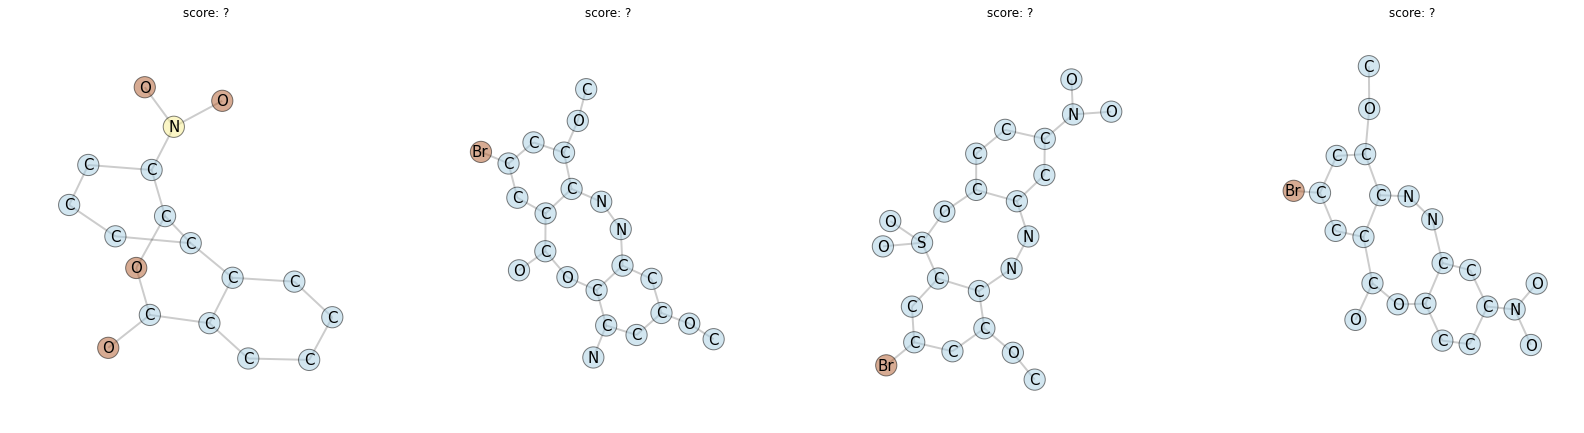

_propose_graph: iteration 0 ; core 0 of 3 ; original_cips tried  0 ; size 45
_propose_graph: iteration 1 ; core 0 of 9 ; original_cips tried  0 ; size 45
_propose_graph: iteration 2 ; core 0 of 9 ; original_cips tried  0 ; size 51
_propose_graph: iteration 3 ; core 0 of 10 ; original_cips tried  0 ; size 55
_propose_graph: iteration 4 ; core 0 of 10 ; original_cips tried  0 ; size 55
_propose_graph: iteration 5 ; core 0 of 9 ; original_cips tried  0 ; size 55
_propose_graph: iteration 6 ; core 0 of 9 ; original_cips tried  0 ; size 55
_propose_graph: iteration 7 ; core 0 of 9 ; original_cips tried  0 ; size 49
_propose_graph: iteration 8 ; core 0 of 5 ; original_cips tried  0 ; size 49
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0 ; size 49
_propose_graph: iteration 10 ; core 0 of 10 ; original_cips tried  0 ; size 49
_propose_graph: iteration 11 ; core 0 of 3 ; original_cips tried  0 ; size 49
_propose_graph: iteration 12 ; core 0 of 9 ; original_cips tried  0 ; s

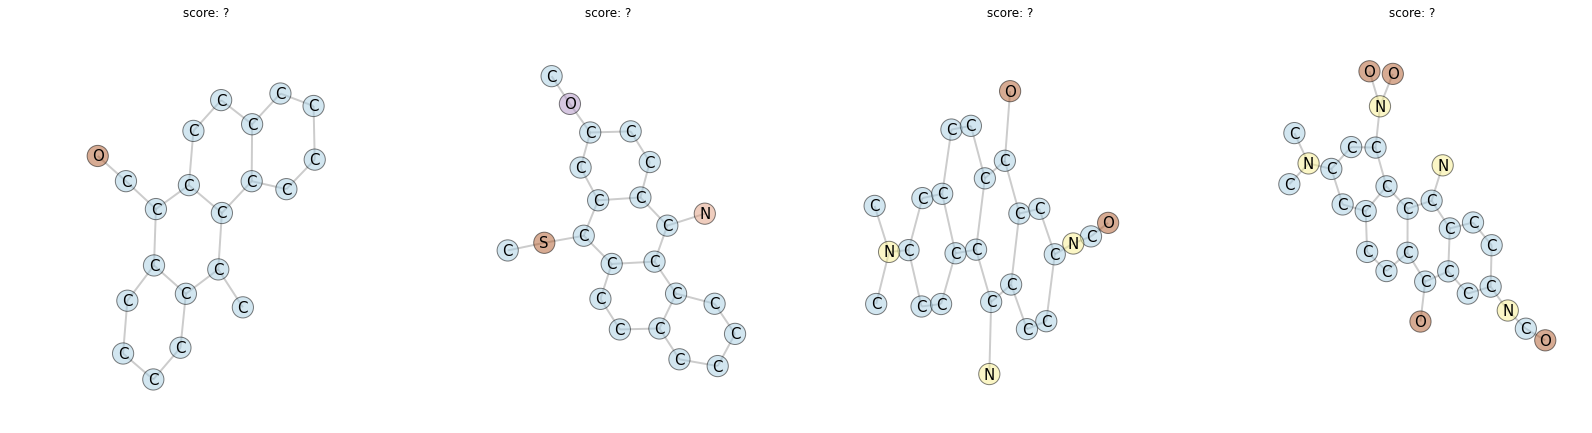

CPU times: user 28.5 s, sys: 1.34 s, total: 29.9 s
Wall time: 31.8 s


In [25]:
%%time
# plot examples of sampling paths
from graphlearn.utils import draw
scores=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    draw.graphlearn(graphlist,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=450,
                   headlinehook=draw.get_score_of_graph)

In [26]:
sampler.monitors[1][9] 

{'accepted:': [False],
 'debug': ['debuglevel:5 accept_orig_cip: True False',
  'debuglevel:5 accept_orig_cip: True False',
  'debuglevel:5 accept_orig_cip: True False',
  'debuglevel:5 accept_orig_cip: True False',
  'debuglevel:5 accept_orig_cip: True True',
  'debuglevel:5 reverse_direction_modifier: 1.006667',
  'debuglevel:10 _propose_graph: iteration 9 ; core 0 of 5 ; original_cips tried  0 ; size 53'],
 'graphwrapper': <graphlearn.graph.Wrapper at 0x7fee24d84690>,
 'id': 9,
 'score': [0.29217805009626668],
 'substitution': ['root: 19 , newcip: 730915 / 1012309']}

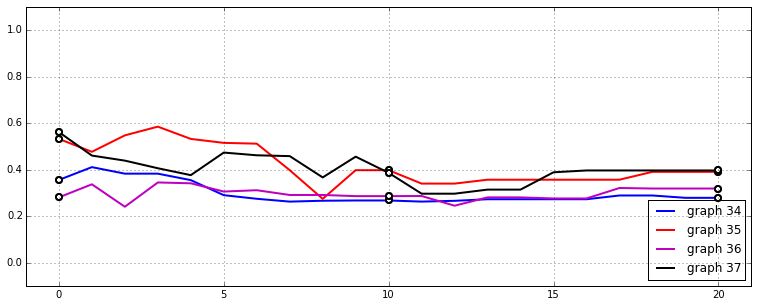

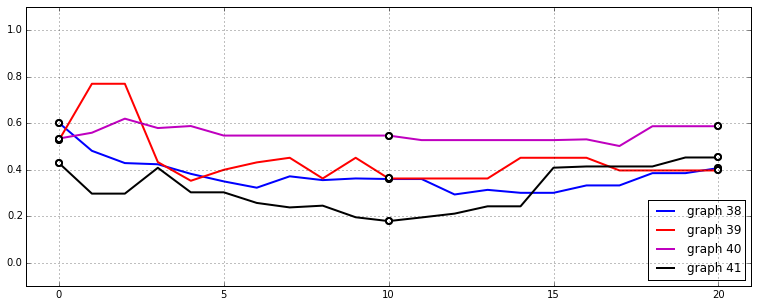

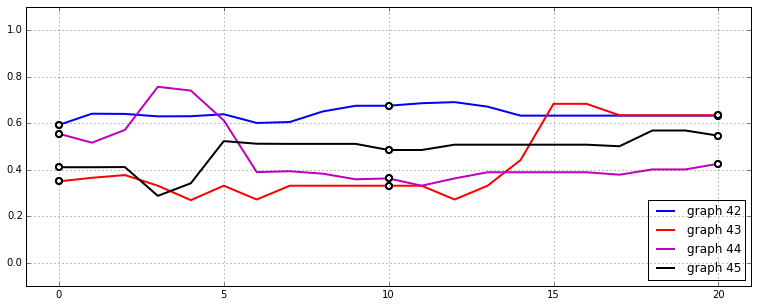

CPU times: user 880 ms, sys: 20 ms, total: 900 ms
Wall time: 893 ms


In [27]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
markevery=n_steps/(n_samples-1)
step=1
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):

    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

.

{4: 5}


'1'